<a href="https://colab.research.google.com/github/sejeong-park/Deeplearning_system/blob/main/ResNet50_CIFAR50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ResNet50 : CIFAR50


In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Hyper-parameter
num_epochs=10
batch_size=100
learning_rate=0.001

In [ ]:
#Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [ ]:
#CIFAR-10 dataset
train_dataset=torchvision.datasets.CIFAR10(root='../../data/',
                                           train=True,
                                           transform=transform,
                                           download=True)

In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

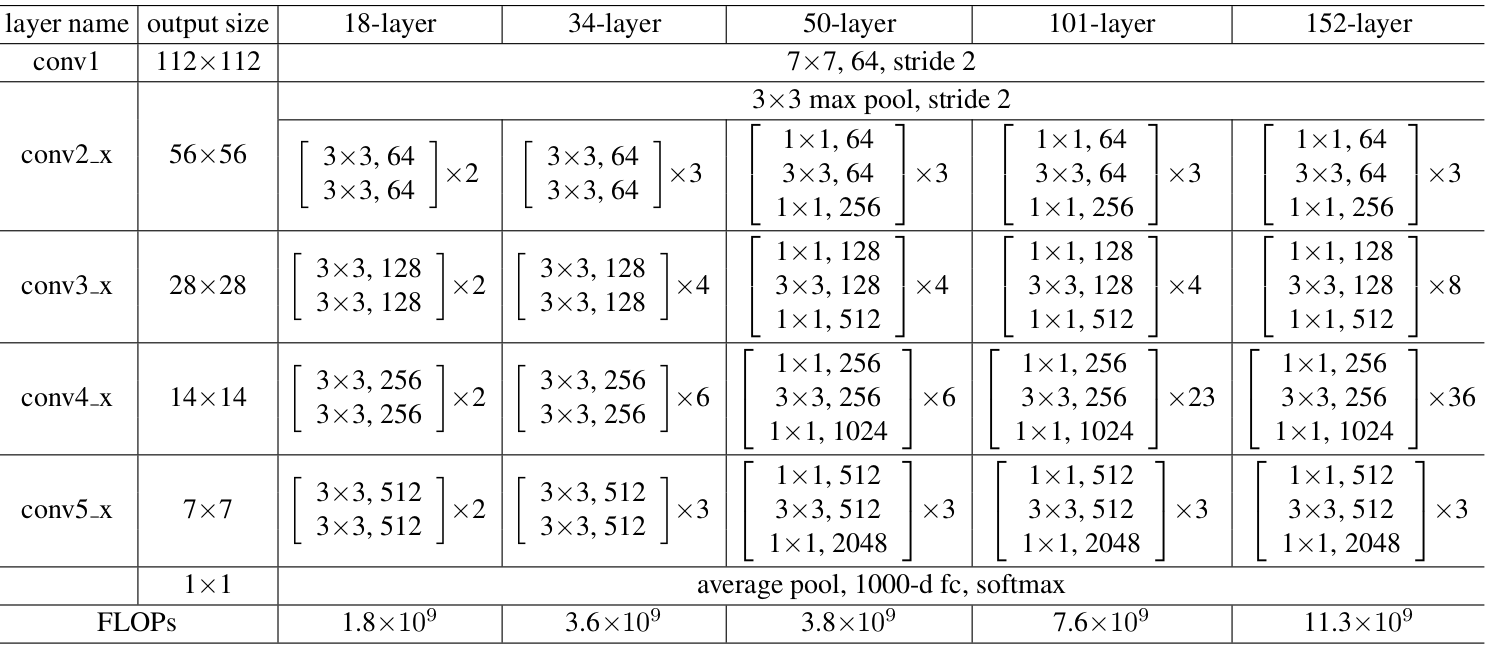

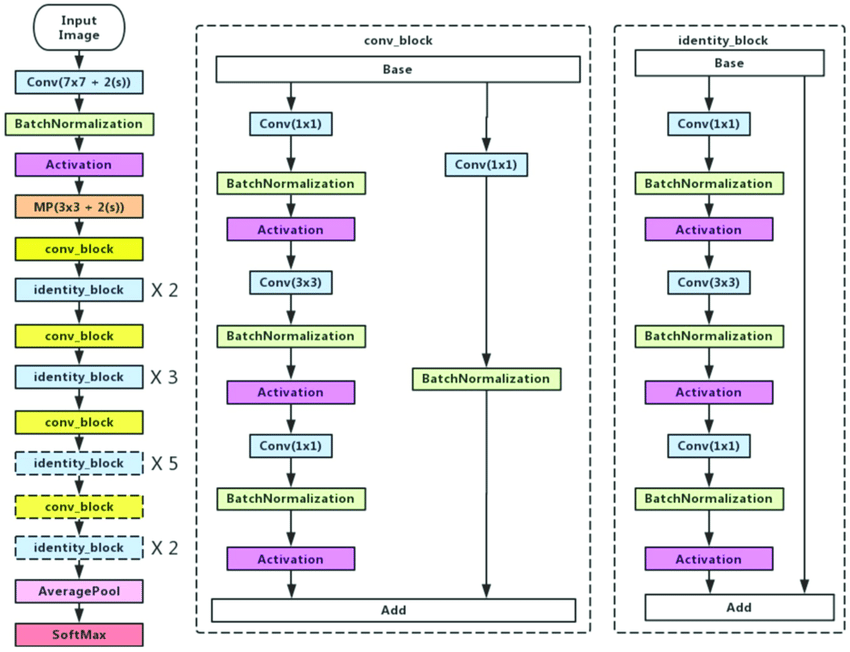

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/10], Step [100/500] Loss: 0.4242
Epoch [1/10], Step [200/500] Loss: 0.4444
Epoch [1/10], Step [300/500] Loss: 0.3565
Epoch [1/10], Step [400/500] Loss: 0.2855
Epoch [1/10], Step [500/500] Loss: 0.3941
Epoch [2/10], Step [100/500] Loss: 0.4758
Epoch [2/10], Step [200/500] Loss: 0.2761
Epoch [2/10], Step [300/500] Loss: 0.3652
Epoch [2/10], Step [400/500] Loss: 0.4615
Epoch [2/10], Step [500/500] Loss: 0.5379
Epoch [3/10], Step [100/500] Loss: 0.3266
Epoch [3/10], Step [200/500] Loss: 0.4328
Epoch [3/10], Step [300/500] Loss: 0.3275
Epoch [3/10], Step [400/500] Loss: 0.3999
Epoch [3/10], Step [500/500] Loss: 0.3975
Epoch [4/10], Step [100/500] Loss: 0.4254
Epoch [4/10], Step [200/500] Loss: 0.4847
Epoch [4/10], Step [300/500] Loss: 0.2940
Epoch [4/10], Step [400/500] Loss: 0.5112
Epoch [4/10], Step [500/500] Loss: 0.3512
Epoch [5/10], Step [100/500] Loss: 0.4533
Epoch [5/10], Step [200/500] Loss: 0.3323
Epoch [5/10], Step [300/500] Loss: 0.5439
Epoch [5/10], Step [400/500] Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 83.76 %


Optimizer => Momentum

In [41]:
optimizer2 = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [43]:
# For updating learning rate
def update_lr(optimizer2, lr):    
    for param_group in optimizer2.param_groups:
        param_group['lr'] = lr

In [44]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer2, curr_lr)

Epoch [1/10], Step [100/500] Loss: 2.2043
Epoch [1/10], Step [200/500] Loss: 2.0146
Epoch [1/10], Step [300/500] Loss: 1.8737
Epoch [1/10], Step [400/500] Loss: 1.7511
Epoch [1/10], Step [500/500] Loss: 1.9939
Epoch [2/10], Step [100/500] Loss: 1.5735
Epoch [2/10], Step [200/500] Loss: 1.4793
Epoch [2/10], Step [300/500] Loss: 1.0328
Epoch [2/10], Step [400/500] Loss: 0.4689
Epoch [2/10], Step [500/500] Loss: 0.4377
Epoch [3/10], Step [100/500] Loss: 0.4966
Epoch [3/10], Step [200/500] Loss: 0.4576
Epoch [3/10], Step [300/500] Loss: 0.4757
Epoch [3/10], Step [400/500] Loss: 0.4692
Epoch [3/10], Step [500/500] Loss: 0.3839
Epoch [4/10], Step [100/500] Loss: 0.4906
Epoch [4/10], Step [200/500] Loss: 0.3930
Epoch [4/10], Step [300/500] Loss: 0.4414
Epoch [4/10], Step [400/500] Loss: 0.4240
Epoch [4/10], Step [500/500] Loss: 0.3984
Epoch [5/10], Step [100/500] Loss: 0.8705
Epoch [5/10], Step [200/500] Loss: 0.3168
Epoch [5/10], Step [300/500] Loss: 0.4431
Epoch [5/10], Step [400/500] Loss:

In [46]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 84.72 %


In [47]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

In [48]:
optimizer3 = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)

In [49]:
# For updating learning rate
def update_lr(optimizer3, lr):    
    for param_group in optimizer3.param_groups:
        param_group['lr'] = lr

In [50]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer3, curr_lr)

Epoch [1/10], Step [100/500] Loss: 0.2244
Epoch [1/10], Step [200/500] Loss: 0.3843
Epoch [1/10], Step [300/500] Loss: 0.2541
Epoch [1/10], Step [400/500] Loss: 0.2645
Epoch [1/10], Step [500/500] Loss: 0.3351
Epoch [2/10], Step [100/500] Loss: 0.2529
Epoch [2/10], Step [200/500] Loss: 0.2154
Epoch [2/10], Step [300/500] Loss: 0.3191
Epoch [2/10], Step [400/500] Loss: 0.3386
Epoch [2/10], Step [500/500] Loss: 0.4832
Epoch [3/10], Step [100/500] Loss: 0.2056
Epoch [3/10], Step [200/500] Loss: 0.4695
Epoch [3/10], Step [300/500] Loss: 0.2990
Epoch [3/10], Step [400/500] Loss: 0.4887
Epoch [3/10], Step [500/500] Loss: 0.3326
Epoch [4/10], Step [100/500] Loss: 0.3265
Epoch [4/10], Step [200/500] Loss: 0.3675
Epoch [4/10], Step [300/500] Loss: 0.2876
Epoch [4/10], Step [400/500] Loss: 0.3161
Epoch [4/10], Step [500/500] Loss: 0.2142
Epoch [5/10], Step [100/500] Loss: 0.1984
Epoch [5/10], Step [200/500] Loss: 0.1883
Epoch [5/10], Step [300/500] Loss: 0.3279
Epoch [5/10], Step [400/500] Loss:

In [51]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 86.72 %
